In [11]:
import random
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV

PROJECT_ROOT = Path.cwd()
DATA_ROOT = (PROJECT_ROOT.parent / "data").resolve()

DEVICE = torch.device("cpu")  # ("cuda" if torch.cuda.is_available() else "cpu")
DEFAULT_IMG_SIZE = 32
PIN_MEMORY = torch.cuda.is_available()

if hasattr(datasets.FashionMNIST, "classes"):
    CLASS_NAMES = list(datasets.FashionMNIST.classes)
else:
    CLASS_NAMES = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed()
print(f"Initialized notebook on {DEVICE} | data root: {DATA_ROOT}")

Initialized notebook on cpu | data root: /home/lovro/Documents/FER/NM/projetk/data



Reusable helpers that download Fashion-MNIST, apply normalization/resizing, and expose `get_data_loaders(batch_size)`.

In [12]:
def build_transforms(img_size: int = DEFAULT_IMG_SIZE) -> transforms.Compose:
    """Return the canonical Fashion-MNIST preprocessing pipeline."""
    return transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])


def load_fashion_mnist(img_size: int = DEFAULT_IMG_SIZE):
    transform = build_transforms(img_size)
    train_dataset = datasets.FashionMNIST(root=DATA_ROOT, train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root=DATA_ROOT, train=False, download=True, transform=transform)
    return train_dataset, test_dataset


def get_data_loaders(
    batch_size: int = 64,
    val_split: float = 0.1,
    num_workers: int = 2,
    seed: int = 42,
    img_size: int = DEFAULT_IMG_SIZE,
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """Return train/validation/test loaders with identical transforms."""
    train_dataset, test_dataset = load_fashion_mnist(img_size)
    val_size = int(len(train_dataset) * val_split)
    train_size = len(train_dataset) - val_size
    set_seed(seed)
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
    loader_kwargs = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=PIN_MEMORY, drop_last=False)
    train_loader = DataLoader(train_subset, shuffle=True, **loader_kwargs)
    val_loader = DataLoader(val_subset, shuffle=False, **loader_kwargs)
    test_loader = DataLoader(test_dataset, shuffle=False, **loader_kwargs)
    return train_loader, val_loader, test_loader



### Task 3.1 – Canonical LeNet-5 Definition
Implements the two-conv, three-FC reference architecture with dynamic flattening so any square `img_size` works.

In [13]:
class LeNet5(nn.Module):
    """Classic LeNet-5: 2 conv blocks (with AvgPool) followed by 3 fully connected layers."""

    def __init__(self, input_channels: int = 1, num_classes: int = 10, img_size: int = DEFAULT_IMG_SIZE):
        super().__init__()
        self.img_size = img_size
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=5, stride=1, padding=0)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)

        with torch.no_grad():
            dummy = torch.zeros(1, input_channels, img_size, img_size)
            features = self._forward_features(dummy)
            flatten_dim = features.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flatten_dim, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def _forward_features(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._forward_features(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

### Task 3.2 + Task 4 Utilities – Training, Evaluation, and History Tracking
Focused helper functions (train/eval loops, metric collection, and history plotting) to keep experiments reproducible.

In [14]:
def _move_batch(xb: torch.Tensor, yb: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    return xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)


def _train_one_epoch(model: nn.Module, loader: DataLoader, criterion, optimizer) -> Dict[str, float]:
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = _move_batch(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += float(loss.item()) * xb.size(0)
        running_correct += (torch.argmax(logits, dim=1) == yb).sum().item()
        total += xb.size(0)
    return {"loss": running_loss / total, "acc": running_correct / total}


def _eval_one_epoch(model: nn.Module, loader: DataLoader, criterion) -> Dict[str, float]:
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = _move_batch(xb, yb)
            logits = model(xb)
            loss = criterion(logits, yb)
            running_loss += float(loss.item()) * xb.size(0)
            running_correct += (torch.argmax(logits, dim=1) == yb).sum().item()
            total += xb.size(0)
    return {"loss": running_loss / total, "acc": running_correct / total}


def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                epochs: int = 5, lr: float = 1e-3, weight_decay: float = 1e-4,
                optimizer_name: str = "adam") -> List[Dict[str, float]]:
    optimizer_name = optimizer_name.lower()
    if optimizer_name == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unsupported optimizer {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    history: List[Dict[str, float]] = []
    for epoch in range(1, epochs + 1):
        train_stats = _train_one_epoch(model, train_loader, criterion, optimizer)
        val_stats = _eval_one_epoch(model, val_loader, criterion)
        history.append({
            "epoch": epoch,
            "train_loss": train_stats["loss"],
            "train_acc": train_stats["acc"],
            "val_loss": val_stats["loss"],
            "val_acc": val_stats["acc"],
        })
    return history


def evaluate_model(model: nn.Module, loader: DataLoader) -> Dict[str, np.ndarray]:
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_correct = 0
    total = 0
    logits_store, prob_store, target_store = [], [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = _move_batch(xb, yb)
            logits = model(xb)
            loss = criterion(logits, yb)
            probs = torch.softmax(logits, dim=1)
            logits_store.append(logits.cpu().numpy())
            prob_store.append(probs.cpu().numpy())
            target_store.append(yb.cpu().numpy())
            total_loss += float(loss.item()) * xb.size(0)
            total_correct += (torch.argmax(logits, dim=1) == yb).sum().item()
            total += xb.size(0)

    return {
        "loss": total_loss / total,
        "accuracy": total_correct / total,
        "logits": np.concatenate(logits_store, axis=0),
        "probabilities": np.concatenate(prob_store, axis=0),
        "targets": np.concatenate(target_store, axis=0),
    }


def plot_history(history: List[Dict[str, float]]) -> None:
    if not history:
        print("History is empty.")
        return

    epochs = [row["epoch"] for row in history]
    train_loss = [row["train_loss"] for row in history]
    val_loss = [row["val_loss"] for row in history]
    train_acc = [row["train_acc"] for row in history]
    val_acc = [row["val_acc"] for row in history]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(epochs, train_loss, label="Train")
    axes[0].plot(epochs, val_loss, label="Val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Cross-Entropy")
    axes[0].legend()

    axes[1].plot(epochs, train_acc, label="Train")
    axes[1].plot(epochs, val_acc, label="Val")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm: np.ndarray, class_names: List[str] | None = None) -> None:
    class_names = class_names or CLASS_NAMES
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel="True label",
        xlabel="Predicted label",
        title="Confusion Matrix",
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0 if cm.size else 0.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > thresh else "black"
            ax.text(j, i, f"{cm[i, j]}", ha="center", va="center", color=color)
    plt.tight_layout()
    plt.show()


def render_classification_report(y_true: np.ndarray, y_pred: np.ndarray, class_names: List[str] | None = None) -> str:
    class_names = class_names or CLASS_NAMES
    return classification_report(y_true, y_pred, target_names=class_names)


def plot_roc_curves(probabilities: np.ndarray, targets: np.ndarray, class_names: List[str] | None = None) -> None:
    class_names = class_names or CLASS_NAMES
    y_true_bin = label_binarize(targets, classes=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(7, 7))
    for idx, name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, idx], probabilities[:, idx])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
    ax.plot([0, 1], [0, 1], "k--", label="Chance")
    ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], xlabel="False Positive Rate", ylabel="True Positive Rate", title="ROC Curves")
    ax.legend(loc="lower right", fontsize="small")
    plt.tight_layout()
    plt.show()


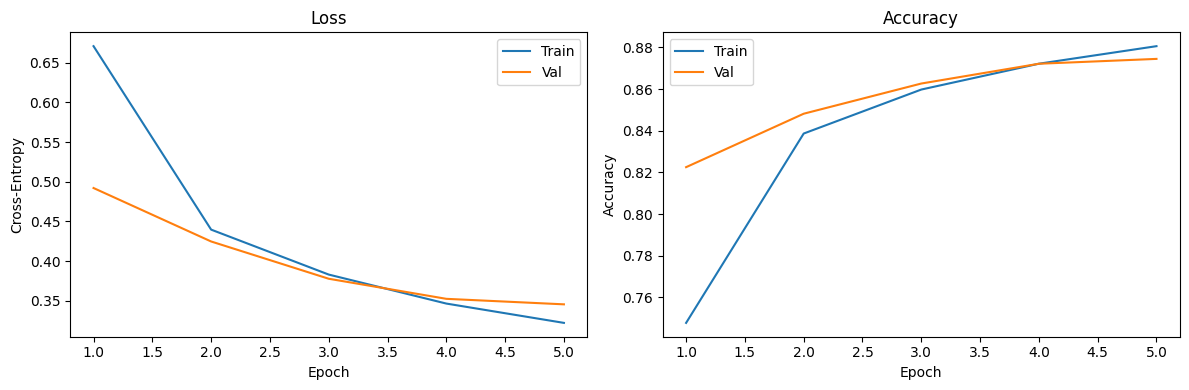

Test accuracy: 0.8691


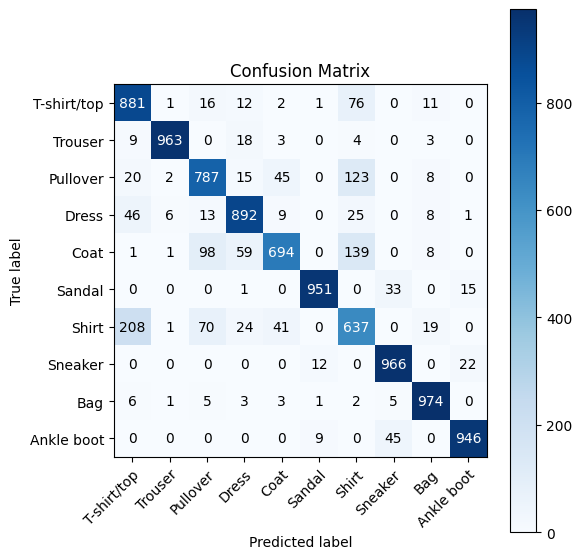

              precision    recall  f1-score   support

 T-shirt/top       0.75      0.88      0.81      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.80      0.79      0.79      1000
       Dress       0.87      0.89      0.88      1000
        Coat       0.87      0.69      0.77      1000
      Sandal       0.98      0.95      0.96      1000
       Shirt       0.63      0.64      0.64      1000
     Sneaker       0.92      0.97      0.94      1000
         Bag       0.94      0.97      0.96      1000
  Ankle boot       0.96      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



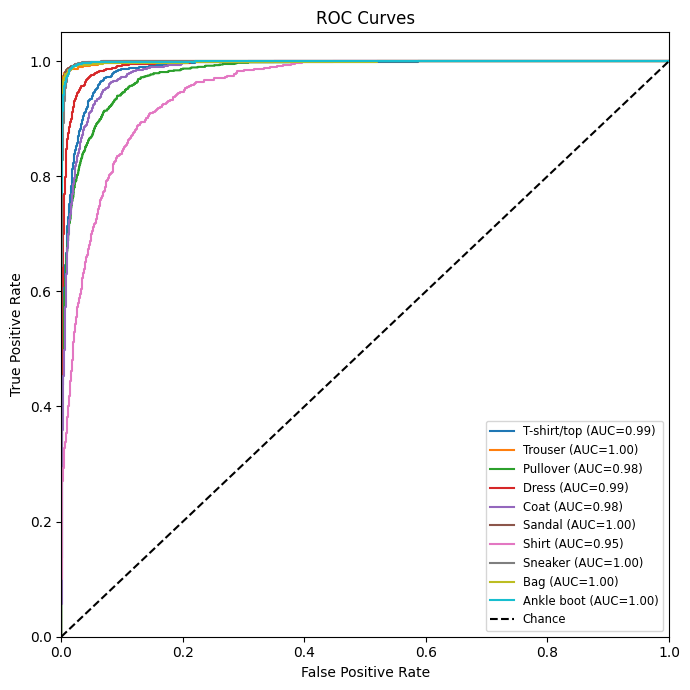

In [15]:
BASELINE_CFG = {
    "batch_size": 64,
    "epochs": 5,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "optimizer_name": "adam",
}

train_loader, val_loader, test_loader = get_data_loaders(batch_size=BASELINE_CFG["batch_size"], img_size=DEFAULT_IMG_SIZE)
baseline_model = LeNet5(img_size=DEFAULT_IMG_SIZE).to(DEVICE)

RUN_BASELINE = True  # Set to True to launch end-to-end training/evaluation

if RUN_BASELINE:
    history = train_model(
        baseline_model,
        train_loader,
        val_loader,
        epochs=BASELINE_CFG["epochs"],
        lr=BASELINE_CFG["lr"],
        weight_decay=BASELINE_CFG["weight_decay"],
        optimizer_name=BASELINE_CFG["optimizer_name"],
    )
    plot_history(history)
    test_metrics = evaluate_model(baseline_model, test_loader)
    print(f"Test accuracy: {test_metrics['accuracy']:.4f}")
    predictions = np.argmax(test_metrics["logits"], axis=1)
    cm = confusion_matrix(test_metrics["targets"], predictions)
    plot_confusion_matrix(cm)
    print(render_classification_report(test_metrics["targets"], predictions))
    plot_roc_curves(test_metrics["probabilities"], test_metrics["targets"])

### Task 3.3 – GridSearchCV Plan (LeNet-5 Only)
Wrap the PyTorch module with a scikit-learn estimator so we can scan learning-rate, batch-size, regularization, and optimizer choices.

In [17]:
class TorchClassifier(BaseEstimator, ClassifierMixin):
    """Sklearn-compatible wrapper tailored for LeNet-5 experiments."""

    def __init__(
        self,
        model_class=LeNet5,
        model_kwargs=None,
        lr: float = 1e-3,
        batch_size: int = 64,
        epochs: int = 5,
        optimizer_name: str = "adam",
        weight_decay: float = 0.0,
        momentum: float = 0.9,
        device: str | None = None,
        seed: int = 42,
        verbose: int = 0,
    ):
        self.model_class = model_class
        self.model_kwargs = model_kwargs or {"input_channels": 1, "num_classes": 10, "img_size": DEFAULT_IMG_SIZE}
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer_name = optimizer_name
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.device = device
        self.seed = seed
        self.verbose = verbose
        self.model_ = None
        self.classes_ = None

    def _resolve_device(self):
        if self.device is not None:
            return torch.device(self.device)
        return DEVICE

    def _set_seed(self):
        set_seed(self.seed)

    def _make_optimizer(self, params):
        name = self.optimizer_name.lower()
        if name == "adam":
            return torch.optim.Adam(params, lr=self.lr, weight_decay=self.weight_decay)
        if name == "sgd":
            return torch.optim.SGD(params, lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        raise ValueError(f"Unknown optimizer {self.optimizer_name}")

    def fit(self, X, y):
        self._set_seed()
        device = self._resolve_device()
        X_t = torch.as_tensor(X, dtype=torch.float32)
        y_t = torch.as_tensor(y, dtype=torch.long)
        dataset = torch.utils.data.TensorDataset(X_t, y_t)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        self.model_ = self.model_class(**self.model_kwargs).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = self._make_optimizer(self.model_.parameters())
        self.classes_ = np.unique(np.asarray(y))
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            total = 0
            for xb, yb in loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad(set_to_none=True)
                logits = self.model_(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()
                epoch_loss += float(loss.item()) * xb.size(0)
                total += xb.size(0)
            if self.verbose:
                print(f"[TorchClassifier] epoch {epoch+1}/{self.epochs} loss={epoch_loss/total:.4f}")
        return self

    def predict(self, X):
        if self.model_ is None:
            raise RuntimeError("Call fit before predict.")
        device = self._resolve_device()
        X_t = torch.as_tensor(X, dtype=torch.float32)
        dataset = torch.utils.data.TensorDataset(X_t)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        preds = []
        with torch.no_grad():
            for (xb,) in loader:
                logits = self.model_(xb.to(device))
                preds.append(torch.argmax(logits, dim=1).cpu().numpy())
        return np.concatenate(preds, axis=0)

    def predict_proba(self, X):
        if self.model_ is None:
            raise RuntimeError("Call fit before predict_proba.")
        device = self._resolve_device()
        X_t = torch.as_tensor(X, dtype=torch.float32)
        dataset = torch.utils.data.TensorDataset(X_t)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        probs = []
        with torch.no_grad():
            for (xb,) in loader:
                logits = self.model_(xb.to(device))
                probs.append(torch.softmax(logits, dim=1).cpu().numpy())
        return np.concatenate(probs, axis=0)

    def score(self, X, y):
        preds = self.predict(X)
        return float((preds == np.asarray(y)).mean())


def dataloader_to_numpy(loader: DataLoader, max_batches: int | None = None) -> Tuple[np.ndarray, np.ndarray]:
    xs, ys = [], []
    for idx, (xb, yb) in enumerate(loader):
        xs.append(xb.numpy())
        ys.append(yb.numpy())
        if max_batches is not None and idx + 1 >= max_batches:
            break
    return np.concatenate(xs, axis=0), np.concatenate(ys, axis=0)


param_grid = {
    "lr": [1e-2, 5e-3, 1e-3, 5e-4],
    "batch_size": [32, 64, 128, 256],
    "epochs": [5, 10, 15],
    "optimizer_name": ["adam", "sgd"],
    "weight_decay": [0.0, 1e-4, 5e-4, 1e-3],
}


lenet_estimator = TorchClassifier(device=str(DEVICE))
lenet_grid = GridSearchCV(lenet_estimator, param_grid=param_grid, cv=3, n_jobs=4, verbose=2)

X_train_sub, y_train_sub = dataloader_to_numpy(train_loader, max_batches=120)
lenet_grid.fit(X_train_sub, y_train_sub)
print("Best params:", lenet_grid.best_params_)
print("Best CV score:", lenet_grid.best_score_)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits
[CV] END batch_size=32, epochs=5, lr=0.01, optimizer_name=adam, weight_decay=0.0; total time=   2.1s
[CV] END batch_size=32, epochs=5, lr=0.01, optimizer_name=adam, weight_decay=0.0; total time=   2.3s
[CV] END batch_size=32, epochs=5, lr=0.01, optimizer_name=adam, weight_decay=0.0001; total time=   2.8s
[CV] END batch_size=32, epochs=5, lr=0.01, optimizer_name=adam, weight_decay=0.0; total time=   3.1s
[CV] END batch_size=32, epochs=5, lr=0.01, optimizer_name=adam, weight_decay=0.0001; total time=   2.4s
[CV] END batch_size=32, epochs=5, lr=0.01, optimizer_name=adam, weight_decay=0.0001; total time=   2.9s
[CV] END batch_size=32, epochs=5, lr=0.01, optimizer_name=adam, weight_decay=0.0005; total time=   2.3s
[CV] END batch_size=32, epochs=5, lr=0.01, optimizer_name=adam, weight_decay=0.0005; total time=   2.6s
[CV] END batch_size=32, epochs=5, lr=0.01, optimizer_name=adam, weight_decay=0.001; total time=   2.2s
[CV] END b

/home/lovro/Documents/FER/NM/projetk/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best params: {'batch_size': 32, 'epochs': 15, 'lr': 0.005, 'optimizer_name': 'adam', 'weight_decay': 0.0005}
Best CV score: 0.8488281249999999
